Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ PhysMamba 모듈 비활성화 완료
✅ PyTorch 버전: 2.8.0+cu126
✅ 환경 설정 완료!
✅ 데이터 준비 완료: /content/rPPG-Toolbox/data/UBFC-rPPG/subject1
✅ 설정 파일 생성: /content/custom_inference.yaml
✅ 모델 파일 확인 완료
🔄 rPPG-Toolbox 실행 중...
STDOUT: => Merging a config file from /content/custom_inference.yaml
Configuration:
BASE: ['']
DEVICE: cuda:0
INFERENCE:
  BATCH_SIZE: 4
  EVALUATION_METHOD: FFT
  EVALUATION_WINDOW:
    USE_SMALLER_WINDOW: False
    WINDOW_SIZE: 10
  MODEL_PATH: ./final_model_release/UBFC-rPPG_TSCAN.pth
LOG:
  PATH: /content/results
MODEL:
  BIGSMALL:
    FRAME_DEPTH: 3
  DROP_RATE: 0.2
  EFFICIENTPHYS:
    FRAME_DEPTH: 10
  FactorizePhys:
    CHANNELS: 3
    FRAME_NUM: 160
    MD_FSAM: False
    MD_INFERENCE: True
    MD_R: 1
    MD_RESIDUAL: True
    MD_S: 1
    MD_STEPS: 4
    MD_TRANSFORM: T_KAB
    MD_TYPE: NMF
    TYPE: Standard
  MODEL_DIR: /content/results/_SizeW128_Size

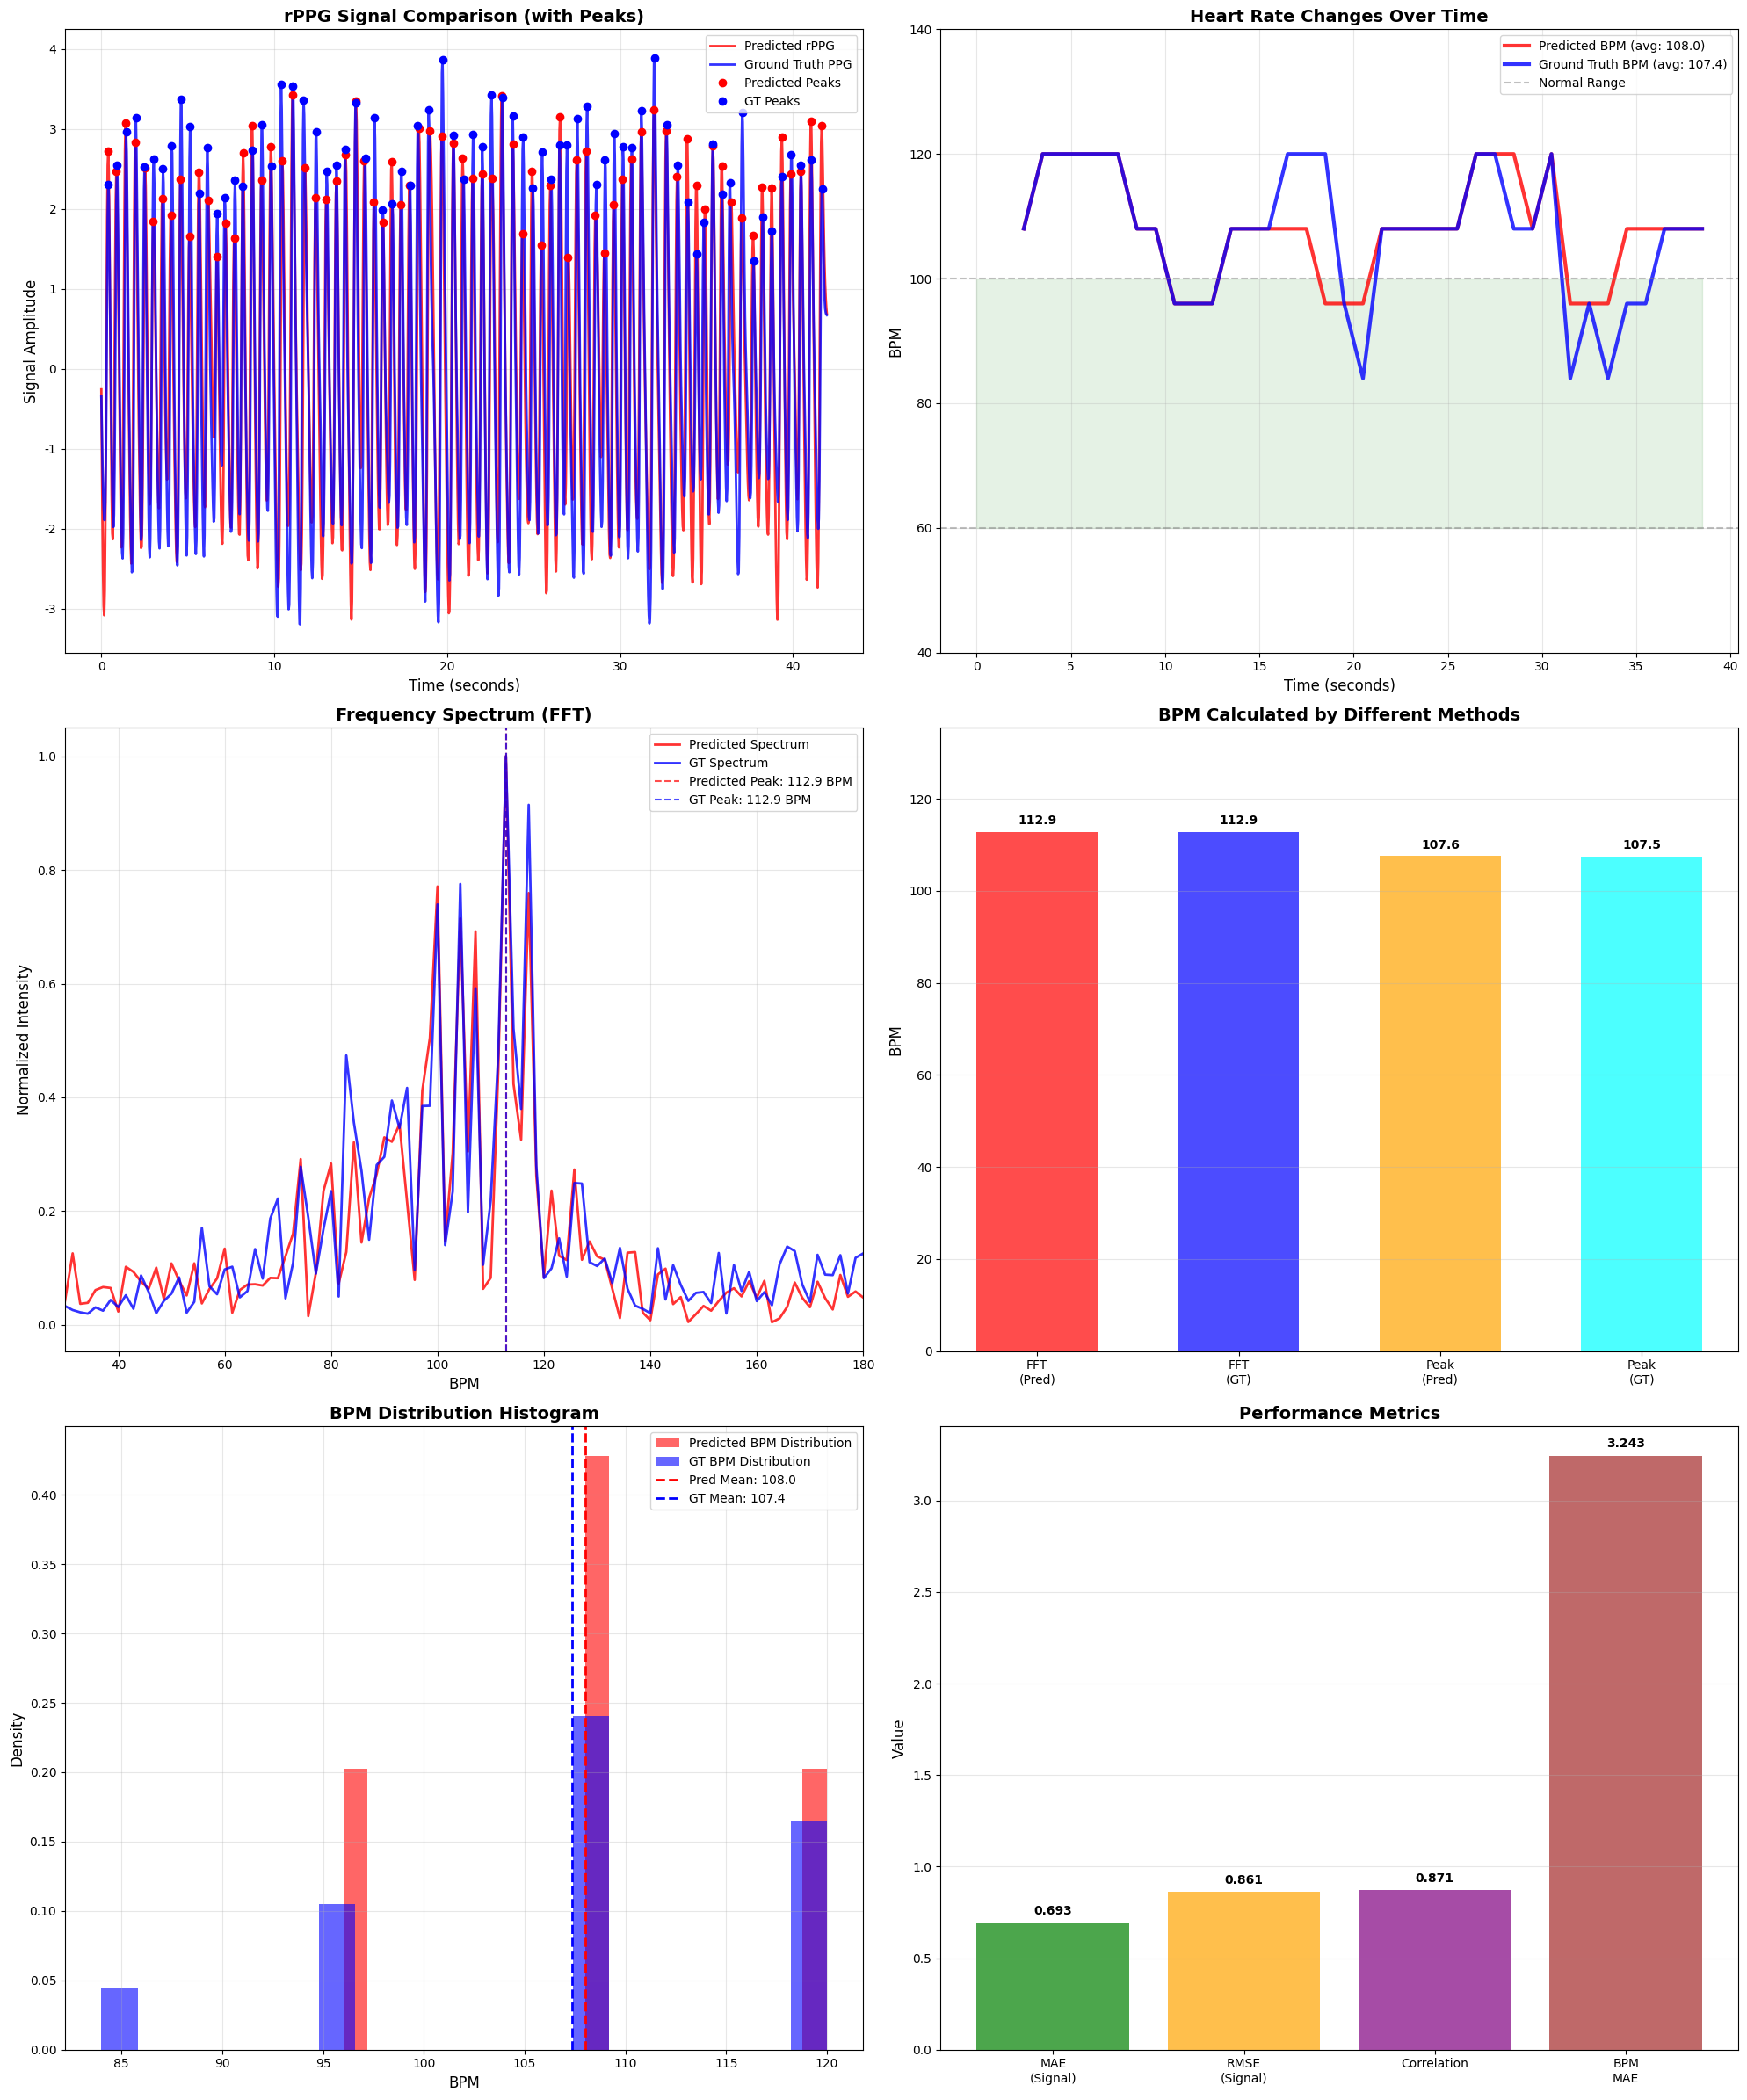


📊 확장된 BPM 분석 결과
🎯 전체 BPM:
  📈 FFT 방법 - 예측: 112.9 BPM, 실제: 112.9 BPM
  📈 Peak 방법 - 예측: 107.6 BPM, 실제: 107.5 BPM

💓 시간별 BPM 통계:
  📊 예측 BPM - 평균: 108.0, 표준편차: 8.4
  📊 실제 BPM - 평균: 107.4, 표준편차: 10.8
  📏 BPM MAE: 3.2

📈 신호 품질:
  📊 MAE: 0.6928
  📊 RMSE: 0.8606
  📊 상관계수: 0.8709

⏱️  처리 정보:
  📦 총 신호 길이: 42.0초
  🔍 검출된 피크 수 - 예측: 75, 실제: 75
  📊 BPM 측정 포인트: 37개

🔄 2번 그래프 PNG 파일 생성 중...


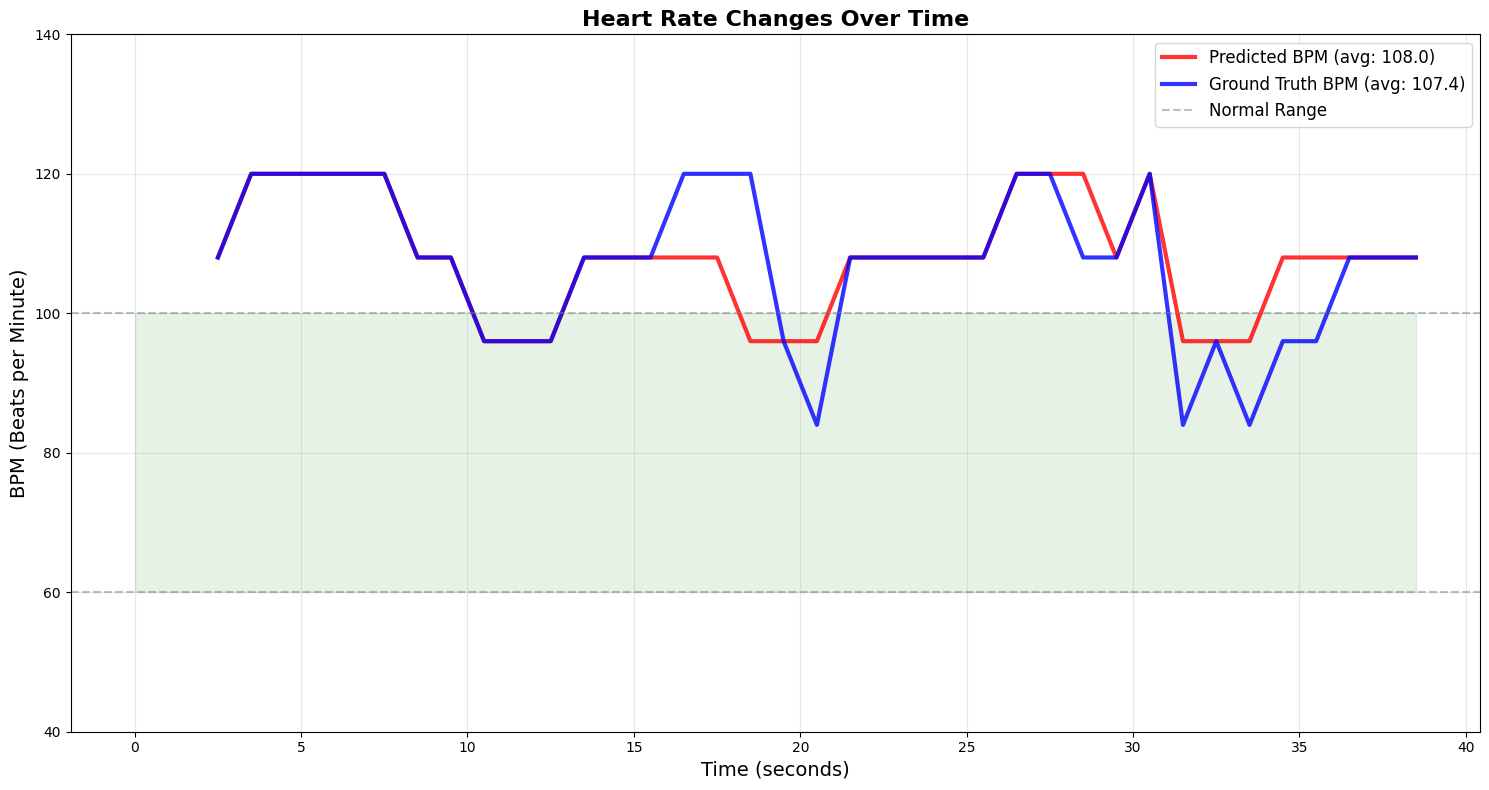

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 2번 그래프 다운로드 완료: /content/bpm_graph.png


In [4]:
# ===================================================================
# 🚀 rPPG-Toolbox 심박수 측정
# ===================================================================

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging

# WARNING 메시지 제거
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

from google.colab import drive
drive.mount('/content/drive')

def setup_environment():
    """환경 설정"""

    # 폰트 설정을 안전한 기본값으로 변경
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False

    # rPPG-Toolbox 다운로드
    if not os.path.exists('/content/rPPG-Toolbox'):
        !git clone https://github.com/ubicomplab/rPPG-Toolbox.git

    os.chdir('/content/rPPG-Toolbox')

    # 기본 패키지 설치
    !pip install -q opencv-python scipy matplotlib pyyaml tqdm scikit-learn
    !pip install -q tensorboardX h5py pandas scikit-image timm
    !pip install -q yacs mat73 neurokit2 thop

    # PhysMamba import 제거 (TSCAN만 사용하므로 문제없음)
    trainer_init_file = "/content/rPPG-Toolbox/neural_methods/trainer/__init__.py"

    if os.path.exists(trainer_init_file):
        with open(trainer_init_file, 'r') as f:
            content = f.read()

        # PhysMamba 관련 import 주석처리
        content = content.replace(
            'import neural_methods.trainer.PhysMambaTrainer',
            '# import neural_methods.trainer.PhysMambaTrainer  # 비활성화됨'
        )

        with open(trainer_init_file, 'w') as f:
            f.write(content)

        print("✅ PhysMamba 모듈 비활성화 완료")

    # PyTorch 확인
    import torch
    print(f"✅ PyTorch 버전: {torch.__version__}")

    sys.path.append('/content/rPPG-Toolbox')
    print("✅ 환경 설정 완료!")

setup_environment()

# ===================================================================
# 2. 데이터 준비
# ===================================================================

def prepare_data():
    """데이터를 UBFC-rPPG 형식으로 준비"""

    source_video = "/content/drive/MyDrive/rMind/vid.avi"
    source_gt = "/content/drive/MyDrive/rMind/ground_truth.txt"

    if not os.path.exists(source_video):
        print(f"❌ 비디오 파일이 없습니다: {source_video}")
        return None

    if not os.path.exists(source_gt):
        print(f"❌ Ground truth 파일이 없습니다: {source_gt}")
        return None

    ubfc_dir = "/content/rPPG-Toolbox/data/UBFC-rPPG"
    subject_dir = os.path.join(ubfc_dir, "subject1")

    os.makedirs(subject_dir, exist_ok=True)

    !cp "{source_video}" "{subject_dir}/vid.avi"
    !cp "{source_gt}" "{subject_dir}/ground_truth.txt"

    print(f"✅ 데이터 준비 완료: {subject_dir}")
    return ubfc_dir

ubfc_data_path = prepare_data()

if ubfc_data_path is None:
    print("❌ 데이터 준비 실패")
    exit()

# ===================================================================
# 3. 설정 파일 생성
# ===================================================================

def create_config():
    """추론용 YAML 설정 파일 생성"""

    config_content = f"""BASE: ['']
TOOLBOX_MODE: "only_test"
TEST:
  METRICS: ['MAE', 'RMSE', 'MAPE', 'Pearson', 'SNR']
  USE_LAST_EPOCH: True
  OUTPUT_SAVE_DIR: "/content/results/"
  DATA:
    FS: 30
    DATASET: UBFC-rPPG
    DO_PREPROCESS: True
    DATA_FORMAT: NDCHW
    DATA_PATH: "{ubfc_data_path}"
    CACHED_PATH: "/content/preprocessed_data"
    EXP_DATA_NAME: "custom_test"
    BEGIN: 0.0
    END: 1.0
    PREPROCESS:
      DATA_TYPE: ['DiffNormalized','Standardized']
      LABEL_TYPE: DiffNormalized
      DO_CHUNK: True
      CHUNK_LENGTH: 180
      CROP_FACE:
        DO_CROP_FACE: True
        BACKEND: 'HC'
        USE_LARGE_FACE_BOX: True
        LARGE_BOX_COEF: 1.5
        DETECTION:
          DO_DYNAMIC_DETECTION: False
          DYNAMIC_DETECTION_FREQUENCY: 30
          USE_MEDIAN_FACE_BOX: False
      RESIZE:
        H: 72
        W: 72
DEVICE: cuda:0
NUM_OF_GPU_TRAIN: 1
LOG:
  PATH: /content/results
MODEL:
  DROP_RATE: 0.2
  NAME: Tscan
  TSCAN:
    FRAME_DEPTH: 10
INFERENCE:
  BATCH_SIZE: 4
  EVALUATION_METHOD: FFT
  EVALUATION_WINDOW:
    USE_SMALLER_WINDOW: False
    WINDOW_SIZE: 10
  MODEL_PATH: "./final_model_release/UBFC-rPPG_TSCAN.pth"
"""

    config_path = "/content/custom_inference.yaml"
    with open(config_path, 'w') as f:
        f.write(config_content)

    print(f"✅ 설정 파일 생성: {config_path}")
    return config_path

config_path = create_config()

# ===================================================================
# 4. 모델 파일 확인
# ===================================================================

def check_model():
    """모델 파일 존재 확인"""
    model_path = "/content/rPPG-Toolbox/final_model_release/UBFC-rPPG_TSCAN.pth"

    if os.path.exists(model_path):
        print("✅ 모델 파일 확인 완료")
        return True
    else:
        print("❌ 모델 파일이 없습니다.")
        return False

if not check_model():
    print("모델 파일을 확인해주세요.")
    exit()

# ===================================================================
# 5. rPPG-Toolbox 실행
# ===================================================================

print("🔄 rPPG-Toolbox 실행 중...")

# 결과 디렉토리 생성
os.makedirs("/content/results", exist_ok=True)
os.makedirs("/content/preprocessed_data", exist_ok=True)

# main.py 실행
import subprocess

try:
    result = subprocess.run([
        'python', 'main.py', '--config_file', config_path
    ], capture_output=True, text=True, cwd='/content/rPPG-Toolbox')

    print("STDOUT:", result.stdout)
    if result.stderr:
        print("STDERR:", result.stderr)

    if result.returncode == 0:
        print("✅ rPPG-Toolbox 실행 완료!")
    else:
        print(f"❌ 실행 실패 (return code: {result.returncode})")

except Exception as e:
    print(f"❌ 실행 중 오류: {e}")

# ===================================================================
# 6. BPM 그래프 시각화
# ===================================================================

def visualize_results():
    """BPM 그래프 시각화"""

    import pickle
    import glob
    from scipy.signal import find_peaks, welch
    from scipy.ndimage import uniform_filter1d

    # 결과 파일 찾기
    possible_locations = [
        "/content/results/**/*.pickle",
        "/content/preprocessed_data/**/*.pickle",
        "/content/rPPG-Toolbox/runs/**/*.pickle",
        "/content/rPPG-Toolbox/**/*output*.pickle"
    ]

    result_files = []
    for pattern in possible_locations:
        result_files.extend(glob.glob(pattern, recursive=True))

    if not result_files:
        print("❌ 결과 파일을 찾을 수 없습니다.")
        return

    result_file = result_files[0]
    print(f"📊 결과 파일 로드: {result_file}")

    try:
        with open(result_file, 'rb') as f:
            results = pickle.load(f)

        print("✅ 결과 파일 로드 성공!")

        # 데이터 추출
        predictions = []
        labels = []

        for key in results['predictions']:
            pred = results['predictions'][key]
            label = results['labels'][key]

            if hasattr(pred, 'cpu'):
                pred = pred.cpu().numpy()
            if hasattr(label, 'cpu'):
                label = label.cpu().numpy()

            if isinstance(pred, dict):
                for v in pred.values():
                    if hasattr(v, 'flatten'):
                        predictions.extend(v.flatten())
                    elif isinstance(v, (list, np.ndarray)):
                        predictions.extend(np.array(v).flatten())
                    else:
                        predictions.append(float(v))
            elif hasattr(pred, 'flatten'):
                predictions.extend(pred.flatten())
            elif isinstance(pred, (list, np.ndarray)):
                predictions.extend(np.array(pred).flatten())
            else:
                predictions.append(float(pred))

            if isinstance(label, dict):
                for v in label.values():
                    if hasattr(v, 'flatten'):
                        labels.extend(v.flatten())
                    elif isinstance(v, (list, np.ndarray)):
                        labels.extend(np.array(v).flatten())
                    else:
                        labels.append(float(v))
            elif hasattr(label, 'flatten'):
                labels.extend(label.flatten())
            elif isinstance(label, (list, np.ndarray)):
                labels.extend(np.array(label).flatten())
            else:
                labels.append(float(label))

        predictions = np.array(predictions)
        labels = np.array(labels)

        # 신호 길이 맞추기
        min_len = min(len(predictions), len(labels))
        predictions = predictions[:min_len]
        labels = labels[:min_len]

        # 신호 후처리
        pred_signal = np.cumsum(predictions)
        gt_signal = np.cumsum(labels)

        pred_signal = pred_signal - np.mean(pred_signal)
        gt_signal = gt_signal - np.mean(gt_signal)

        # 밴드패스 필터링
        from scipy.signal import butter, filtfilt

        def bandpass_filter(signal, fs=30, low=0.6, high=3.3):
            if len(signal) < 10:
                return signal
            try:
                nyquist = fs / 2
                b, a = butter(1, [low/nyquist, high/nyquist], btype='band')
                return filtfilt(b, a, signal)
            except:
                return signal

        pred_signal = bandpass_filter(pred_signal)
        gt_signal = bandpass_filter(gt_signal)

        fs = 30  # 샘플링 주파수

        # ===================================================================
        # 🎯 다양한 BPM 분석 함수들
        # ===================================================================

        def calculate_sliding_bpm(signal, window_size=150, step=30, fs=30):
            """슬라이딩 윈도우로 시간에 따른 BPM 계산"""
            bpm_values = []
            time_points = []

            for i in range(0, len(signal) - window_size, step):
                window = signal[i:i + window_size]
                if len(window) >= window_size:
                    try:
                        freqs = np.fft.fftfreq(len(window), 1/fs)
                        fft_signal = np.abs(np.fft.fft(window))
                        mask = (freqs >= 0.6) & (freqs <= 3.3)
                        if np.any(mask):
                            peak_freq = freqs[mask][np.argmax(fft_signal[mask])]
                            bpm = peak_freq * 60
                            bpm_values.append(bpm)
                            time_points.append((i + window_size/2) / fs)
                    except:
                        continue

            return np.array(time_points), np.array(bpm_values)

        def get_fft_spectrum(signal, fs=30):
            """FFT 스펙트럼 계산"""
            freqs = np.fft.fftfreq(len(signal), 1/fs)
            fft_signal = np.abs(np.fft.fft(signal))

            # 양의 주파수만 선택
            pos_mask = freqs >= 0
            freqs = freqs[pos_mask]
            fft_signal = fft_signal[pos_mask]

            # 심박수 범위로 제한 (0.5-4.0 Hz = 30-240 BPM)
            hr_mask = (freqs >= 0.5) & (freqs <= 4.0)

            return freqs[hr_mask], fft_signal[hr_mask]

        def detect_peaks_bpm(signal, fs=30, height_threshold=0.3):
            """피크 검출을 통한 BPM 계산"""
            # 피크 검출
            peaks, properties = find_peaks(signal,
                                         height=np.max(signal) * height_threshold,
                                         distance=int(fs * 0.4))  # 최소 0.4초 간격

            if len(peaks) < 2:
                return 0, peaks

            # 피크 간 간격으로 BPM 계산
            peak_intervals = np.diff(peaks) / fs  # 초 단위
            avg_interval = np.mean(peak_intervals)
            bpm = 60 / avg_interval if avg_interval > 0 else 0

            return bpm, peaks

        def calculate_overall_bpm(signal, fs=30):
            """전체 신호의 BPM 계산"""
            try:
                freqs = np.fft.fftfreq(len(signal), 1/fs)
                fft_signal = np.abs(np.fft.fft(signal))
                mask = (freqs >= 0.6) & (freqs <= 3.3)
                if np.any(mask):
                    peak_freq = freqs[mask][np.argmax(fft_signal[mask])]
                    return peak_freq * 60
                return 0
            except:
                return 0

        # BPM 계산
        overall_pred_bpm = calculate_overall_bpm(pred_signal, fs)
        overall_gt_bpm = calculate_overall_bpm(gt_signal, fs)

        # 시간에 따른 BPM 변화 계산
        time_pred, bpm_pred = calculate_sliding_bpm(pred_signal)
        time_gt, bpm_gt = calculate_sliding_bpm(gt_signal)

        # FFT 스펙트럼 계산
        freq_pred, fft_pred = get_fft_spectrum(pred_signal)
        freq_gt, fft_gt = get_fft_spectrum(gt_signal)

        # 피크 검출 BPM
        peak_pred_bpm, pred_peaks = detect_peaks_bpm(pred_signal)
        peak_gt_bpm, gt_peaks = detect_peaks_bpm(gt_signal)

        # ===================================================================
        # 🎨 확장된 시각화 (6개 서브플롯)
        # ===================================================================

        fig = plt.figure(figsize=(20, 24))

        # 1. 원본 rPPG 신호 비교
        plt.subplot(3, 2, 1)
        time_axis = np.arange(len(pred_signal)) / fs
        plt.plot(time_axis, pred_signal, 'r-', linewidth=2, label='Predicted rPPG', alpha=0.8)
        plt.plot(time_axis, gt_signal, 'b-', linewidth=2, label='Ground Truth PPG', alpha=0.8)

        # 피크 표시
        if len(pred_peaks) > 0:
            plt.plot(pred_peaks/fs, pred_signal[pred_peaks], 'ro', markersize=6, label='Predicted Peaks')
        if len(gt_peaks) > 0:
            plt.plot(gt_peaks/fs, gt_signal[gt_peaks], 'bo', markersize=6, label='GT Peaks')

        plt.xlabel('Time (seconds)', fontsize=12)
        plt.ylabel('Signal Amplitude', fontsize=12)
        plt.title('rPPG Signal Comparison (with Peaks)', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # 2. 시간에 따른 BPM 변화
        plt.subplot(3, 2, 2)
        if len(time_pred) > 0:
            plt.plot(time_pred, bpm_pred, 'r-', linewidth=3, label=f'Predicted BPM (avg: {np.mean(bpm_pred):.1f})', alpha=0.8)
        if len(time_gt) > 0:
            plt.plot(time_gt, bpm_gt, 'b-', linewidth=3, label=f'Ground Truth BPM (avg: {np.mean(bpm_gt):.1f})', alpha=0.8)

        plt.axhline(y=60, color='gray', linestyle='--', alpha=0.5, label='Normal Range')
        plt.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
        plt.fill_between([0, max(time_pred) if len(time_pred) > 0 else 10], 60, 100, alpha=0.1, color='green')

        plt.xlabel('Time (seconds)', fontsize=12)
        plt.ylabel('BPM', fontsize=12)
        plt.title('Heart Rate Changes Over Time', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.ylim(40, 140)

        # 3. FFT 주파수 스펙트럼 (BPM)
        plt.subplot(3, 2, 3)
        bpm_pred_freq = freq_pred * 60  # Hz를 BPM으로 변환
        bpm_gt_freq = freq_gt * 60

        plt.plot(bpm_pred_freq, fft_pred/np.max(fft_pred) if np.max(fft_pred) > 0 else fft_pred,
                'r-', linewidth=2, label='Predicted Spectrum', alpha=0.8)
        plt.plot(bpm_gt_freq, fft_gt/np.max(fft_gt) if np.max(fft_gt) > 0 else fft_gt,
                'b-', linewidth=2, label='GT Spectrum', alpha=0.8)

        # 피크 주파수 표시
        if len(fft_pred) > 0:
            peak_idx_pred = np.argmax(fft_pred)
            plt.axvline(x=bpm_pred_freq[peak_idx_pred], color='red', linestyle='--', alpha=0.7,
                       label=f'Predicted Peak: {bpm_pred_freq[peak_idx_pred]:.1f} BPM')

        if len(fft_gt) > 0:
            peak_idx_gt = np.argmax(fft_gt)
            plt.axvline(x=bpm_gt_freq[peak_idx_gt], color='blue', linestyle='--', alpha=0.7,
                       label=f'GT Peak: {bpm_gt_freq[peak_idx_gt]:.1f} BPM')

        plt.xlabel('BPM', fontsize=12)
        plt.ylabel('Normalized Intensity', fontsize=12)
        plt.title('Frequency Spectrum (FFT)', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.xlim(30, 180)

        # 4. BPM 비교 막대 그래프 (여러 방법)
        plt.subplot(3, 2, 4)
        methods = ['FFT\n(Pred)', 'FFT\n(GT)', 'Peak\n(Pred)', 'Peak\n(GT)']
        values = [
            overall_pred_bpm,
            overall_gt_bpm,
            peak_pred_bpm,
            peak_gt_bpm
        ]
        colors = ['red', 'blue', 'orange', 'cyan']

        bars = plt.bar(methods, values, color=colors, alpha=0.7, width=0.6)
        plt.ylabel('BPM', fontsize=12)
        plt.title('BPM Calculated by Different Methods', fontsize=14, fontweight='bold')
        plt.ylim(0, max(max(values), 100) * 1.2)

        # 막대 위에 값 표시
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.grid(True, alpha=0.3, axis='y')

        # 5. BPM 히스토그램
        plt.subplot(3, 2, 5)
        if len(bpm_pred) > 0:
            plt.hist(bpm_pred, bins=20, alpha=0.6, color='red', label='Predicted BPM Distribution', density=True)
        if len(bpm_gt) > 0:
            plt.hist(bpm_gt, bins=20, alpha=0.6, color='blue', label='GT BPM Distribution', density=True)

        plt.axvline(x=np.mean(bpm_pred) if len(bpm_pred) > 0 else 0, color='red',
                   linestyle='--', linewidth=2, label=f'Pred Mean: {np.mean(bpm_pred):.1f}' if len(bpm_pred) > 0 else 'N/A')
        plt.axvline(x=np.mean(bpm_gt) if len(bpm_gt) > 0 else 0, color='blue',
                   linestyle='--', linewidth=2, label=f'GT Mean: {np.mean(bpm_gt):.1f}' if len(bpm_gt) > 0 else 'N/A')

        plt.xlabel('BPM', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.title('BPM Distribution Histogram', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # 6. 성능 메트릭 시각화
        plt.subplot(3, 2, 6)

        # 성능 메트릭 계산
        mae = np.mean(np.abs(pred_signal - gt_signal)) if len(pred_signal) > 0 else 0
        rmse = np.sqrt(np.mean((pred_signal - gt_signal) ** 2)) if len(pred_signal) > 0 else 0
        try:
            correlation = np.corrcoef(pred_signal, gt_signal)[0, 1] if len(pred_signal) > 1 else 0
            if np.isnan(correlation):
                correlation = 0.0
        except:
            correlation = 0.0

        bpm_mae = np.mean(np.abs(bpm_pred - bpm_gt)) if len(bpm_pred) > 0 and len(bpm_gt) > 0 else 0

        metrics = ['MAE\n(Signal)', 'RMSE\n(Signal)', 'Correlation', 'BPM\nMAE']
        metric_values = [mae, rmse, abs(correlation), bpm_mae]
        metric_colors = ['green', 'orange', 'purple', 'brown']

        bars = plt.bar(metrics, metric_values, color=metric_colors, alpha=0.7)
        plt.ylabel('Value', fontsize=12)
        plt.title('Performance Metrics', fontsize=14, fontweight='bold')

        for bar, value in zip(bars, metric_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metric_values)*0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        # ===================================================================
        # 📊 상세한 결과 출력
        # ===================================================================

        print("\n" + "="*80)
        print("📊 확장된 BPM 분석 결과")
        print("="*80)

        print("🎯 전체 BPM:")
        print(f"  📈 FFT 방법 - 예측: {overall_pred_bpm:.1f} BPM, 실제: {overall_gt_bpm:.1f} BPM")
        print(f"  📈 Peak 방법 - 예측: {peak_pred_bpm:.1f} BPM, 실제: {peak_gt_bpm:.1f} BPM")

        if len(bpm_pred) > 0 and len(bpm_gt) > 0:
            print(f"\n💓 시간별 BPM 통계:")
            print(f"  📊 예측 BPM - 평균: {np.mean(bpm_pred):.1f}, 표준편차: {np.std(bpm_pred):.1f}")
            print(f"  📊 실제 BPM - 평균: {np.mean(bpm_gt):.1f}, 표준편차: {np.std(bpm_gt):.1f}")
            print(f"  📏 BPM MAE: {bpm_mae:.1f}")

        print(f"\n📈 신호 품질:")
        print(f"  📊 MAE: {mae:.4f}")
        print(f"  📊 RMSE: {rmse:.4f}")
        print(f"  📊 상관계수: {correlation:.4f}")

        print(f"\n⏱️  처리 정보:")
        print(f"  📦 총 신호 길이: {len(pred_signal)/fs:.1f}초")
        print(f"  🔍 검출된 피크 수 - 예측: {len(pred_peaks)}, 실제: {len(gt_peaks)}")
        print(f"  📊 BPM 측정 포인트: {len(bpm_pred)}개" if len(bpm_pred) > 0 else "  📊 BPM 측정 포인트: 0개")

        print("="*80)

        # ===================================================================
        # 💾 2번 그래프 (Heart Rate Changes Over Time) PNG 저장
        # ===================================================================

        print("\n🔄 2번 그래프 PNG 파일 생성 중...")

        from google.colab import files

        # 2번 그래프만 별도로 생성
        plt.figure(figsize=(15, 8))

        if len(time_pred) > 0:
            plt.plot(time_pred, bpm_pred, 'r-', linewidth=3,
                    label=f'Predicted BPM (avg: {np.mean(bpm_pred):.1f})', alpha=0.8)
        if len(time_gt) > 0:
            plt.plot(time_gt, bpm_gt, 'b-', linewidth=3,
                    label=f'Ground Truth BPM (avg: {np.mean(bpm_gt):.1f})', alpha=0.8)

        # 정상 심박수 범위 표시
        plt.axhline(y=60, color='gray', linestyle='--', alpha=0.5, label='Normal Range')
        plt.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
        max_time = max(time_pred) if len(time_pred) > 0 else (max(time_gt) if len(time_gt) > 0 else 10)
        plt.fill_between([0, max_time], 60, 100, alpha=0.1, color='green')

        plt.xlabel('Time (seconds)', fontsize=14)
        plt.ylabel('BPM (Beats per Minute)', fontsize=14)
        plt.title('Heart Rate Changes Over Time', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.ylim(40, 140)
        plt.tight_layout()

        # PNG 파일로 저장
        save_path = "/content/bpm_graph.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

        # 그래프 표시
        plt.show()

        # 파일 다운로드
        try:
            files.download(save_path)
            print(f"✅ 2번 그래프 다운로드 완료: {save_path}")
        except Exception as e:
            print(f"❌ 다운로드 중 오류: {e}")
            print(f"💡 파일 위치: {save_path}")


    except Exception as e:
        print(f"❌ 결과 처리 중 오류: {e}")
        import traceback
        traceback.print_exc()

# 시각화 실행
visualize_results()

🔍 성능 분석을 위한 데이터 로드 중...
📊 결과 파일 로드: /content/results/custom_test/saved_test_outputs/UBFC-rPPG_TSCAN_UBFC-rPPG_outputs.pickle


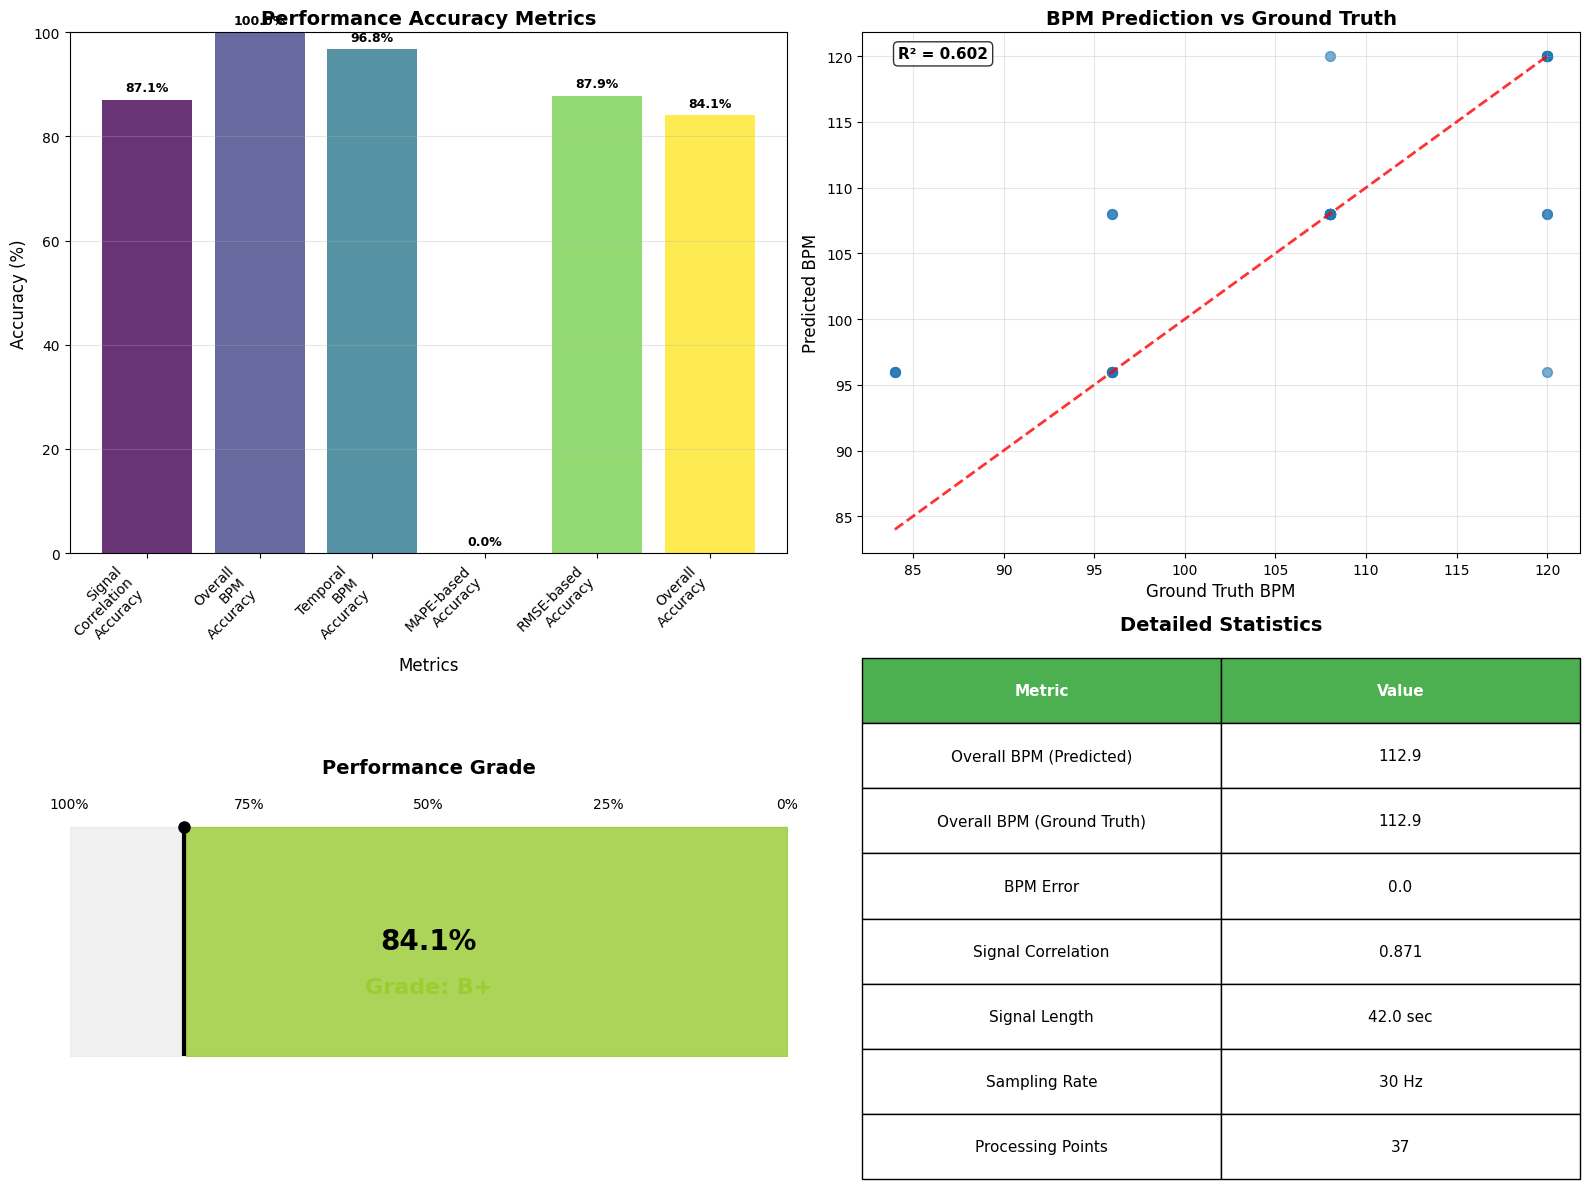


🎯 성능 정확도 분석 결과
✅ Signal Correlation Accuracy: 87.1%
✅ Overall BPM Accuracy: 100.0%
✅ Temporal BPM Accuracy: 96.8%
❌ MAPE-based Accuracy: 0.0%
✅ RMSE-based Accuracy: 87.9%
✅ Overall Accuracy: 84.1%

🏆 종합 성능 등급: B+ (84.1%)
👍 양호한 성능! 대부분의 상황에서 신뢰할 수 있습니다.


In [7]:
# ===================================================================
# 📈 정확도 성능 측정 (두 번째 셀)
# ===================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import glob

def calculate_accuracy_metrics():
    """다양한 방법으로 정확도 성능을 계산"""

    print("🔍 성능 분석을 위한 데이터 로드 중...")

    # 결과 파일 찾기 (첫 번째 셀과 동일한 로직)
    possible_locations = [
        "/content/results/**/*.pickle",
        "/content/preprocessed_data/**/*.pickle",
        "/content/rPPG-Toolbox/runs/**/*.pickle",
        "/content/rPPG-Toolbox/**/*output*.pickle"
    ]

    result_files = []
    for pattern in possible_locations:
        result_files.extend(glob.glob(pattern, recursive=True))

    if not result_files:
        print("❌ 결과 파일을 찾을 수 없습니다.")
        return None

    result_file = result_files[0]
    print(f"📊 결과 파일 로드: {result_file}")

    try:
        with open(result_file, 'rb') as f:
            results = pickle.load(f)

        # 데이터 추출 (첫 번째 셀과 동일한 로직)
        predictions = []
        labels = []

        for key in results['predictions']:
            pred = results['predictions'][key]
            label = results['labels'][key]

            if hasattr(pred, 'cpu'):
                pred = pred.cpu().numpy()
            if hasattr(label, 'cpu'):
                label = label.cpu().numpy()

            if isinstance(pred, dict):
                for v in pred.values():
                    if hasattr(v, 'flatten'):
                        predictions.extend(v.flatten())
                    elif isinstance(v, (list, np.ndarray)):
                        predictions.extend(np.array(v).flatten())
                    else:
                        predictions.append(float(v))
            elif hasattr(pred, 'flatten'):
                predictions.extend(pred.flatten())
            elif isinstance(pred, (list, np.ndarray)):
                predictions.extend(np.array(pred).flatten())
            else:
                predictions.append(float(pred))

            if isinstance(label, dict):
                for v in label.values():
                    if hasattr(v, 'flatten'):
                        labels.extend(v.flatten())
                    elif isinstance(v, (list, np.ndarray)):
                        labels.extend(np.array(v).flatten())
                    else:
                        labels.append(float(v))
            elif hasattr(label, 'flatten'):
                labels.extend(label.flatten())
            elif isinstance(label, (list, np.ndarray)):
                labels.extend(np.array(label).flatten())
            else:
                labels.append(float(label))

        predictions = np.array(predictions)
        labels = np.array(labels)

        # 신호 길이 맞추기
        min_len = min(len(predictions), len(labels))
        predictions = predictions[:min_len]
        labels = labels[:min_len]

        # 신호 후처리
        pred_signal = np.cumsum(predictions)
        gt_signal = np.cumsum(labels)

        pred_signal = pred_signal - np.mean(pred_signal)
        gt_signal = gt_signal - np.mean(gt_signal)

        # 밴드패스 필터링
        from scipy.signal import butter, filtfilt

        def bandpass_filter(signal, fs=30, low=0.6, high=3.3):
            if len(signal) < 10:
                return signal
            try:
                nyquist = fs / 2
                b, a = butter(1, [low/nyquist, high/nyquist], btype='band')
                return filtfilt(b, a, signal)
            except:
                return signal

        pred_signal = bandpass_filter(pred_signal)
        gt_signal = bandpass_filter(gt_signal)

        # ===================================================================
        # 🎯 BPM 계산 함수들
        # ===================================================================

        def calculate_overall_bpm(signal, fs=30):
            """전체 신호의 BPM 계산"""
            try:
                freqs = np.fft.fftfreq(len(signal), 1/fs)
                fft_signal = np.abs(np.fft.fft(signal))
                mask = (freqs >= 0.6) & (freqs <= 3.3)
                if np.any(mask):
                    peak_freq = freqs[mask][np.argmax(fft_signal[mask])]
                    return peak_freq * 60
                return 0
            except:
                return 0

        def calculate_sliding_bpm(signal, window_size=150, step=30, fs=30):
            """슬라이딩 윈도우로 시간에 따른 BPM 계산"""
            bpm_values = []

            for i in range(0, len(signal) - window_size, step):
                window = signal[i:i + window_size]
                if len(window) >= window_size:
                    try:
                        freqs = np.fft.fftfreq(len(window), 1/fs)
                        fft_signal = np.abs(np.fft.fft(window))
                        mask = (freqs >= 0.6) & (freqs <= 3.3)
                        if np.any(mask):
                            peak_freq = freqs[mask][np.argmax(fft_signal[mask])]
                            bpm = peak_freq * 60
                            bpm_values.append(bpm)
                    except:
                        continue

            return np.array(bpm_values)

        # BPM 계산
        fs = 30
        overall_pred_bpm = calculate_overall_bpm(pred_signal, fs)
        overall_gt_bpm = calculate_overall_bpm(gt_signal, fs)

        bpm_pred = calculate_sliding_bpm(pred_signal)
        bpm_gt = calculate_sliding_bpm(gt_signal)

        # ===================================================================
        # 📊 정확도 메트릭 계산
        # ===================================================================

        accuracy_metrics = {}

        # 1. 신호 유사도 기반 정확도
        try:
            # 정규화
            pred_norm = (pred_signal - np.mean(pred_signal)) / (np.std(pred_signal) + 1e-8)
            gt_norm = (gt_signal - np.mean(gt_signal)) / (np.std(gt_signal) + 1e-8)

            # 상관계수
            correlation, _ = pearsonr(pred_norm, gt_norm)
            if np.isnan(correlation):
                correlation = 0.0

            signal_accuracy = abs(correlation) * 100
            accuracy_metrics['Signal Correlation Accuracy'] = signal_accuracy

        except Exception as e:
            print(f"신호 유사도 계산 오류: {e}")
            accuracy_metrics['Signal Correlation Accuracy'] = 0.0

        # 2. BPM 정확도 (전체)
        if overall_gt_bpm > 0:
            bpm_error_rate = abs(overall_pred_bpm - overall_gt_bpm) / overall_gt_bpm
            overall_bpm_accuracy = max(0, (1 - bpm_error_rate)) * 100
            accuracy_metrics['Overall BPM Accuracy'] = overall_bpm_accuracy
        else:
            accuracy_metrics['Overall BPM Accuracy'] = 0.0

        # 3. 시간별 BPM 정확도
        if len(bpm_pred) > 0 and len(bpm_gt) > 0:
            # 길이 맞추기
            min_bpm_len = min(len(bpm_pred), len(bpm_gt))
            bpm_pred_sync = bpm_pred[:min_bpm_len]
            bpm_gt_sync = bpm_gt[:min_bpm_len]

            # 각 시점별 정확도 계산
            temporal_accuracies = []
            for p_bpm, g_bpm in zip(bpm_pred_sync, bpm_gt_sync):
                if g_bpm > 0:
                    error_rate = abs(p_bpm - g_bpm) / g_bpm
                    acc = max(0, (1 - error_rate)) * 100
                    temporal_accuracies.append(acc)

            if temporal_accuracies:
                temporal_bpm_accuracy = np.mean(temporal_accuracies)
                accuracy_metrics['Temporal BPM Accuracy'] = temporal_bpm_accuracy
            else:
                accuracy_metrics['Temporal BPM Accuracy'] = 0.0
        else:
            accuracy_metrics['Temporal BPM Accuracy'] = 0.0

        # 4. MAPE 기반 정확도
        try:
            mape = np.mean(np.abs((gt_signal - pred_signal) / (gt_signal + 1e-8))) * 100
            mape_accuracy = max(0, 100 - mape)
            accuracy_metrics['MAPE-based Accuracy'] = mape_accuracy
        except:
            accuracy_metrics['MAPE-based Accuracy'] = 0.0

        # 5. RMSE 기반 정확도 (정규화)
        try:
            rmse = np.sqrt(mean_squared_error(gt_signal, pred_signal))
            max_range = max(np.max(gt_signal) - np.min(gt_signal), 1e-8)
            rmse_accuracy = max(0, (1 - rmse / max_range)) * 100
            accuracy_metrics['RMSE-based Accuracy'] = rmse_accuracy
        except:
            accuracy_metrics['RMSE-based Accuracy'] = 0.0

        # 6. 종합 정확도 (가중 평균)
        weights = {
            'Signal Correlation Accuracy': 0.3,
            'Overall BPM Accuracy': 0.25,
            'Temporal BPM Accuracy': 0.25,
            'MAPE-based Accuracy': 0.1,
            'RMSE-based Accuracy': 0.1
        }

        overall_accuracy = sum(accuracy_metrics[key] * weights[key]
                             for key in weights.keys()
                             if key in accuracy_metrics)

        accuracy_metrics['Overall Accuracy'] = overall_accuracy

        # ===================================================================
        # 📊 성능 시각화
        # ===================================================================

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. 정확도 메트릭 막대 그래프
        metrics_names = list(accuracy_metrics.keys())
        metrics_values = list(accuracy_metrics.values())

        colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_names)))
        bars1 = ax1.bar(range(len(metrics_names)), metrics_values, color=colors, alpha=0.8)

        ax1.set_xlabel('Metrics', fontsize=12)
        ax1.set_ylabel('Accuracy (%)', fontsize=12)
        ax1.set_title('Performance Accuracy Metrics', fontsize=14, fontweight='bold')
        ax1.set_xticks(range(len(metrics_names)))
        ax1.set_xticklabels([name.replace(' ', '\n') for name in metrics_names],
                           rotation=45, ha='right', fontsize=10)
        ax1.set_ylim(0, 100)
        ax1.grid(True, alpha=0.3, axis='y')

        # 막대 위에 값 표시
        for bar, value in zip(bars1, metrics_values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

        # 2. BPM 비교 산점도
        if len(bpm_pred) > 0 and len(bpm_gt) > 0:
            min_len = min(len(bpm_pred), len(bpm_gt))
            ax2.scatter(bpm_gt[:min_len], bpm_pred[:min_len], alpha=0.6, s=50)

            # 완벽한 예측 라인
            min_bpm = min(min(bpm_gt[:min_len]), min(bpm_pred[:min_len]))
            max_bpm = max(max(bpm_gt[:min_len]), max(bpm_pred[:min_len]))
            ax2.plot([min_bpm, max_bpm], [min_bpm, max_bpm], 'r--', alpha=0.8, linewidth=2)

            ax2.set_xlabel('Ground Truth BPM', fontsize=12)
            ax2.set_ylabel('Predicted BPM', fontsize=12)
            ax2.set_title('BPM Prediction vs Ground Truth', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)

            # R² 계산
            try:
                r_squared = np.corrcoef(bpm_gt[:min_len], bpm_pred[:min_len])[0, 1] ** 2
                ax2.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax2.transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                        fontsize=11, fontweight='bold')
            except:
                pass

        # 3. 성능 등급 게이지
        overall_acc = accuracy_metrics['Overall Accuracy']

        def get_grade(accuracy):
            if accuracy >= 90: return 'A+', 'darkgreen'
            elif accuracy >= 85: return 'A', 'green'
            elif accuracy >= 80: return 'B+', 'yellowgreen'
            elif accuracy >= 75: return 'B', 'orange'
            elif accuracy >= 70: return 'C+', 'darkorange'
            elif accuracy >= 65: return 'C', 'red'
            else: return 'D', 'darkred'

        grade, color = get_grade(overall_acc)

        # 게이지 차트
        theta = np.linspace(0, np.pi, 100)
        r = np.ones_like(theta)

        # 배경 반원
        ax3.fill_between(theta, 0, r, alpha=0.3, color='lightgray')

        # 성능에 따른 색칠
        acc_theta = np.pi * (1 - overall_acc/100)
        performance_theta = theta[theta >= acc_theta]
        performance_r = r[theta >= acc_theta]
        ax3.fill_between(performance_theta, 0, performance_r, alpha=0.8, color=color)

        # 포인터
        pointer_theta = np.pi * (1 - overall_acc/100)
        ax3.plot([pointer_theta, pointer_theta], [0, 1], 'k-', linewidth=3)
        ax3.plot(pointer_theta, 1, 'ko', markersize=8)

        ax3.set_xlim(0, np.pi)
        ax3.set_ylim(0, 1.2)
        ax3.set_aspect('equal')
        ax3.axis('off')
        ax3.set_title('Performance Grade', fontsize=14, fontweight='bold')

        # 텍스트 표시
        ax3.text(np.pi/2, 0.5, f'{overall_acc:.1f}%', ha='center', va='center',
                fontsize=20, fontweight='bold')
        ax3.text(np.pi/2, 0.3, f'Grade: {grade}', ha='center', va='center',
                fontsize=16, fontweight='bold', color=color)

        # 눈금 표시
        for i, label in enumerate(['100%', '75%', '50%', '25%', '0%']):
            angle = np.pi * i / 4
            ax3.text(angle, 1.1, label, ha='center', va='center', fontsize=10)

        # 4. 상세 통계 테이블
        ax4.axis('off')

        # 상세 통계 계산
        detailed_stats = [
            ['Overall BPM (Predicted)', f'{overall_pred_bpm:.1f}'],
            ['Overall BPM (Ground Truth)', f'{overall_gt_bpm:.1f}'],
            ['BPM Error', f'{abs(overall_pred_bpm - overall_gt_bpm):.1f}'],
            ['Signal Correlation', f'{correlation:.3f}'],
            ['Signal Length', f'{len(pred_signal)/30:.1f} sec'],
            ['Sampling Rate', '30 Hz'],
            ['Processing Points', f'{len(bpm_pred) if len(bpm_pred) > 0 else 0}']
        ]

        # 테이블 생성
        table_data = []
        for stat in detailed_stats:
            table_data.append(stat)

        table = ax4.table(cellText=table_data,
                         colLabels=['Metric', 'Value'],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])

        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)

        # 헤더 스타일링
        for i in range(2):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')

        ax4.set_title('Detailed Statistics', fontsize=14, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.show()

        # ===================================================================
        # 📋 결과 출력
        # ===================================================================

        print("\n" + "="*80)
        print("🎯 성능 정확도 분석 결과")
        print("="*80)

        for metric, value in accuracy_metrics.items():
            status = "✅" if value >= 80 else ("⚠️" if value >= 70 else "❌")
            print(f"{status} {metric}: {value:.1f}%")

        print(f"\n🏆 종합 성능 등급: {grade} ({overall_acc:.1f}%)")

        if overall_acc >= 85:
            print("🌟 우수한 성능! rPPG 측정이 매우 정확합니다.")
        elif overall_acc >= 75:
            print("👍 양호한 성능! 대부분의 상황에서 신뢰할 수 있습니다.")
        elif overall_acc >= 65:
            print("⚠️ 보통 성능. 일부 개선이 필요할 수 있습니다.")
        else:
            print("❌ 성능 개선이 필요합니다. 데이터 품질이나 설정을 확인해보세요.")

        print("="*80)

        return accuracy_metrics

    except Exception as e:
        print(f"❌ 성능 분석 중 오류: {e}")
        import traceback
        traceback.print_exc()
        return None

# 성능 분석 실행
accuracy_results = calculate_accuracy_metrics()